## Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import inflection
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

rcParams['figure.figsize'] = (21, 8)
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.spines.bottom'] = True
rcParams['axes.spines.left'] = True

COLORS = ['#99d594', '#D53E4F', '#FC8D59']

SEED = 0

def load_dataset(path):
    df = pd.read_csv(path)
    df.columns = [inflection.underscore(var) for var in list(df.columns)]    
    return df

def data_preparation(df):
    df = df.copy()
    
    # parsing to string
    variables = ['operating_systems', 'browser', 'region', 'traffic_type', 'weekend']
    df[variables] = df[variables].astype(str)
    
    # parsing month to integer
    df['month'] = df['month'].map({
        #'Jan': 1, 
        'Feb': 2, 'Mar': 3, 
        #'Apr': 4, 
        'May': 5,
        'June': 6, 'Jul': 7, 'Aug': 8, 
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    })
    
    return df

def split_dataset(df, target='revenue', test_size=0.2, seed=SEED):
    return train_test_split(
        df,
        test_size=test_size,
        random_state=seed,
        stratify=df[target]
    )
    
# data preparation
df = load_dataset('online_shoppers_intention.csv')
df = data_preparation(df)

# grouping the variables based on the type
target = 'revenue'
numerical = [
        'administrative', 'administrative_duration', 'informational',
        'informational_duration', 'product_related', 'product_related_duration',
        'bounce_rates', 'exit_rates', 'page_values', 'special_day', 
]
categorical = [
        'month', 'operating_systems', 'browser', 'region', 'traffic_type',
        'visitor_type', 'weekend'
]

## 1. Data Cleansing

Berikut ini strategi untuk data cleansing berdasarkan hasil EDA sebelumnya. Namun, sebelum memulai untuk memanipulasi seluruh feature, dataset dibagi menjadi dua yaitu train set dan test set dengan ratio 80:20.

1. Data duplikasi sebanyak 125 rows di-drop dari seluruh dataset.
2. Outliers pada feature numerik tidak dihapus tetapi jumlahnya dikurangi dengan feature transformation. Feature transformation yang tepat digunakan yaitu:
    * Log-transformation menggunakan `np.log1p`.
    * Power-transformation menggunakan yeo-johnson transformer.
3. Agar feature numerik memiliki range yang sama atau memiliki mean dan standar deviasi yang hampir sama, maka beberapa feature scaling yang tepat digunakan yaitu:
    * MinMaxScaler untuk membuat seluruh feature numerik menjadi di range 0 hingga 1.
    * StandardScaler untuk membuat seluruh feature numerik memiliki mean 0 dan standar deviasi 1.
    * RobustScaler yang men-scale data berdasarkan median dan IQR.
4. Untuk feature kategorikal, perlu feature encoding agar tipe string dapat diubah menjadi tipe int atau float. Berikut ini strategi feature enconding:
    * Sin-cos transformation atau Quarter binning untuk kolom `month`
    * One-hot encoding untuk `visitor_type` dan `weekend` karena jumlah unique value tidak banyak sekitar 2-3.
    * Untuk `operating_systems`, `browser`, `region`, dan `traffic_type` bisa menggunakan
        * Count encoder
        * Frequency encoder
        * target encoder
        * rare-label encoding + one-hot enconding
5. Karena kolom target memiliki class imbalance dengan ratio 85:15 maka berikut cara yang tepat untuk menanganinya
    * Melakukan resampling (oversampling, undersampling, or over-undersampling) agar distribusi target menjadi 50:50.
    * Memberi class weight lebih besar pada minority class dari kolom target
    * Menggunakan metrik evaluasi model yang tepat seperti ROC-AUC atau f1-score.

### 1.1 Handle missing values

In [ ]:
df.isnull().sum().sum()

0

Missing values tidak terdapat pada dataset sehingga tidak ada yang perlu di-handle.

### 1.2 Handle duplicated data

In [ ]:
df.duplicated().sum()

125

In [ ]:
df[df.duplicated(keep=False)].reset_index(drop=True).head()    # show all duplicated data

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,1,1,1,3,Returning_Visitor,False,False
1,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,3,2,3,3,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,1,1,1,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,3,2,3,3,Returning_Visitor,False,False
4,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,3,2,3,3,Returning_Visitor,False,False


In [ ]:
df[df.duplicated(keep='last')]         # show last duplicated data

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
85,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,1,1,1,3,Returning_Visitor,False,False
132,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,3,2,3,3,Returning_Visitor,False,False
159,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,3,2,3,3,Returning_Visitor,False,False
252,0,0.0,0,0.0,2,0.0,0.2,0.2,0.0,0.0,3,1,1,1,1,Returning_Visitor,False,False
286,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,3,2,2,1,1,Returning_Visitor,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11139,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,11,3,2,1,13,Returning_Visitor,False,False
11205,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,12,8,13,9,20,Other,False,False
11581,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,12,8,13,9,20,Other,False,False
11801,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,12,1,1,4,1,Returning_Visitor,True,False


Pada dataset ini terdapat duplicated data sebanyak 125. Walaupun seluruh data merupakan data yang berbeda di setiap visitor, duplicated data harus tetap di drop karena model machine learning tidak dapat mendeteksi perbedaan setiap rows.


In [ ]:
print(f"jumlah rows dengan data duplikasi: {df.shape}")

df = df.drop_duplicates()
print(f"jumlah rows tanpa data duplikasi: {df.shape}")

jumlah rows dengan data duplikasi: (12330, 18)
jumlah rows tanpa data duplikasi: (12205, 18)


### Split dataset


Sebelum data preprocessing dan modelling, data di-split menjadi dua yaitu train set dan test set agar tidak terjadi data leakage. Rasio split yang digunakan 80% train set dan 20% test set. Kemudian agar distribusi target antara train dan test set tetap sama maka menggunakan stratified sampling.

In [ ]:
# set up the validation framework
full_train, test = split_dataset(df, target='revenue', test_size=0.2)

In [ ]:
full_train[target].value_counts(normalize=True)

False    0.843712
True     0.156288
Name: revenue, dtype: float64

In [ ]:
test[target].value_counts(normalize=True)

False    0.843507
True     0.156493
Name: revenue, dtype: float64

### 1.3 Handle outliers & Feature Transformation

Feature-feature numerik di dataset ini memiliki distribusi right-skewed sehingga terlihat jelas outliers yang ada. Namun, karena mayoritas data banyak yang bernilai 0, outliers tidak akan dihapus tetapi akan dikurangi jumlahnya dengan menggunakan log-transformer atau power-transformer. Berikut ini transformer yang akan digunakan.

* `np.log1p`: log(x+1)
* yeo-johnson transformation

Referensi
* [Yeo-johnson](https://statisticaloddsandends.wordpress.com/2021/02/19/the-box-cox-and-yeo-johnson-transformations-for-continuous-variables/)

#### 3.1 Log-transformation

**Kondisi feature numerik sebelum log-transformation**

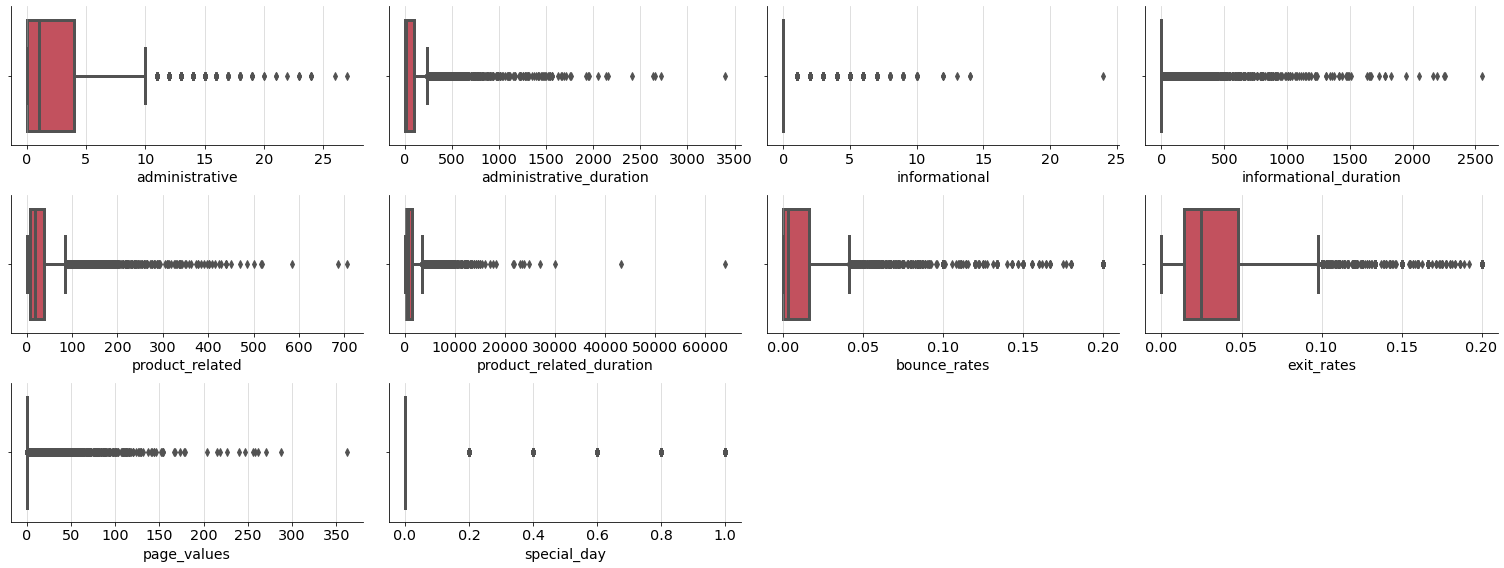

In [ ]:
for i, col in enumerate(numerical):
    plt.subplot(3, 4, i+1)            
    sns.boxplot(
        x=full_train[col], 
        color=COLORS[1], 
        orient='h'
    )
    plt.xlabel(col, fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show() 

**Kondisi feature numerik sesudah log-transformation dengan `np.log1p`**

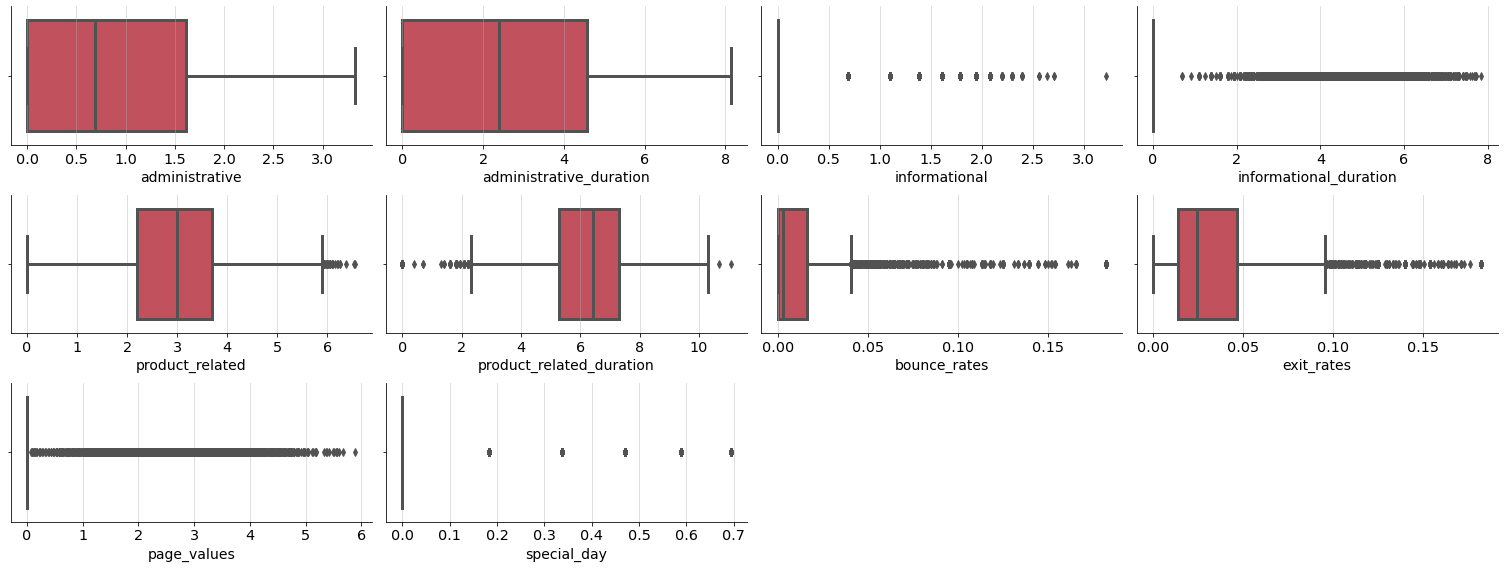

In [ ]:
for i, col in enumerate(numerical):
    plt.subplot(3, 4, i+1)            
    sns.boxplot(
        x=np.log1p(full_train[col]), 
        color=COLORS[1], 
        orient='h'
    )
    plt.xlabel(col, fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show() 

**Pengamatan**
* Kolom yang outliernya berkurang atau bahkan hilang yaitu `administrative`, `administrative_duration`, `product_related`, dan `product_related_duration`. Namun, selain keempat kolom tersebut `np.log1p` transformer tidak memberi dampak apa-apa terhadap distribusi.

**Kondisi feature numerik sesudah transformation dengan yeo-johnson**

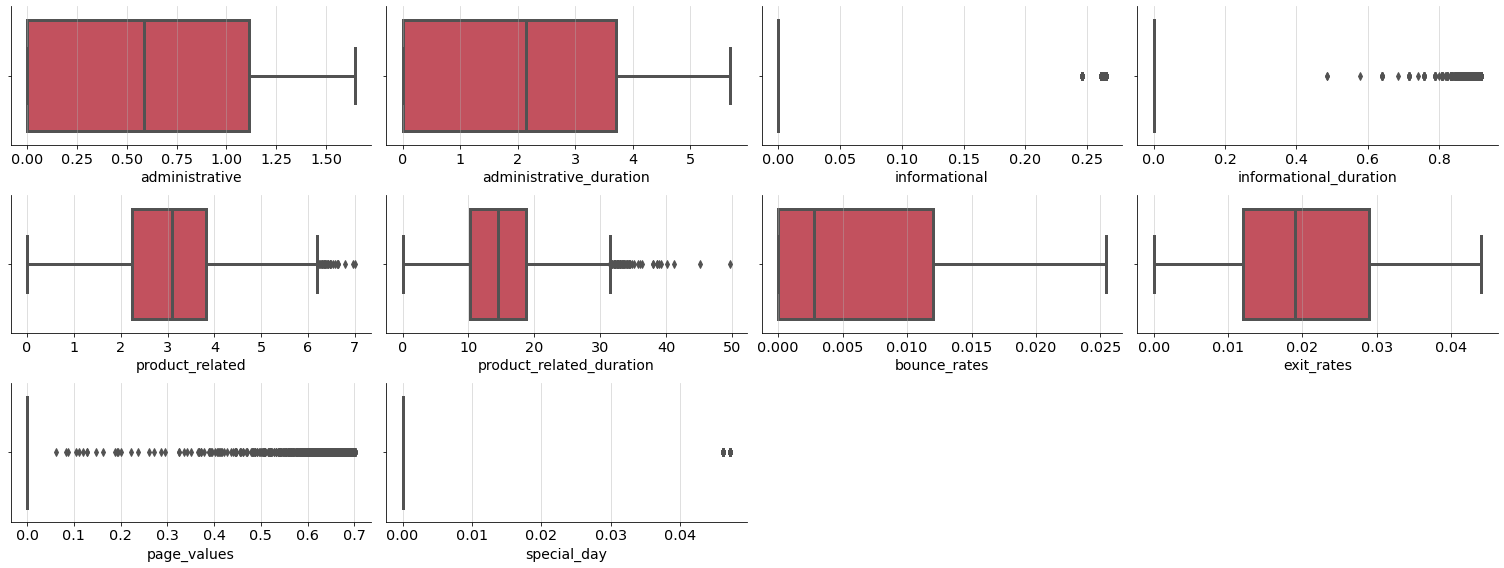

In [ ]:
for i, col in enumerate(numerical):
    plt.subplot(3, 4, i+1)            
    sns.boxplot(
        x=stats.yeojohnson(full_train[col])[0], 
        color=COLORS[1], 
        orient='h'
    )
    plt.xlabel(col, fontsize=14)
    plt.grid(axis='x', alpha=0.5)
    plt.tight_layout()

plt.show() 

**Pengamatan**
* kolom `bounce_rates` dan `exit_rates` tidak memiliki outlier lagi setelah yeo-johnson transformer.

**Kesimpulan log-transformation**
1. Kolom `administrative` dan `administrative_duration` tidak memiliki outliers setelah ditransformasi dengan `np.log1p` dan yeo-johnson.
2. Kolom `bounce_rates` dan `exit_rates` lebih cocok ditransformasi dengan yeo-johnson karena setelah transformasi outliers tidak ada.
3. Untuk kolom `product_related` dan `product_related_duration`, menggunakan kedua transformer tersebut dapat mengurangi outliers secara signifikan.
4. Kolom `informational`, `informational_duration`, `page_values`, dan `special_day` tidak berubah distribusinya setelah transformation. Hal ini terjadi karena
    * Kolom `informational`, `informational_duration`, `page_values` memiliki data yang mayoritas tersebar di dekat nol sehingga saat ditransform dengan `np.log1p` atau yeo-johnson, nilai-nilai yang besar tetap jauh dari nilai 0.
    * Kolom `special_day` hanya memiliki 6 unique values yang mana lebih tepat di-treat sebagai kolom kategorikal. Namun, kolom `special_day` kemungkinan tidak memberi impak ke model karena 89% data memiliki nilai 0.
 
5. Jadi, karena setelah mencoba mentransform dengan kedua transformer tersebut hanya ada empat feature yang outliers hilang, maka untuk tahap modelling akan lebih fokus menggunakan algoritma machine learning yang robust terhadap outlier seperti tree-based classifier dan ensemble classifier.

#### 3.2 Normalisasi atau scaling

Apabila model yang digunakan linear seperti Logistic Regression, maka semua feature harus berada salah satu kondisi dibawah ini 
1. **range yang sama** dengan menggunakan `MinMaxScaler` untuk menskala ulang feature numerik menjadi di range 0 hingga 1.

2. **memiliki mean 0 dan standar deviasi 1**. Kondisi ini dicapai dengan menggunakan `StandardScaler`.

3. jika terdapat banyak outliers, ada kemungkinan scaling menggunakan mean dan variance tidak terlalu membantu meningkatkan performa model. Oleh karena itu, scaling harus menggunakan **median dan IQR** dengan `RobustScaler`

Referensi
* [Preprocessing data, Scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)

**Statistik deskriptif feature numerik sebelum normalisasi**

In [ ]:
desc_nums = full_train[numerical].describe().round(3).T
desc_nums

,count,mean,std,min,25%,50%,75%,max
administrative,9764.0,2.348,3.328,0.0,0.000,1.000,4.000,27.000
administrative_duration,9764.0,82.420,180.052,0.0,0.000,10.000,94.835,3398.750
informational,9764.0,0.505,1.269,0.0,0.000,0.000,0.000,24.000
informational_duration,9764.0,35.634,144.572,0.0,0.000,0.000,0.000,2549.375
product_related,9764.0,32.235,44.923,0.0,8.000,19.000,39.000,705.000
product_related_duration,9764.0,1218.681,1970.936,0.0,197.200,619.783,1500.078,63973.522
bounce_rates,9764.0,0.020,0.045,0.0,0.000,0.003,0.016,0.200
exit_rates,9764.0,0.041,0.046,0.0,0.014,0.025,0.048,0.200
page_values,9764.0,5.893,18.413,0.0,0.000,0.000,0.000,361.764
special_day,9764.0,0.061,0.198,0.0,0.000,0.000,0.000,1.000


**Feature numerik setelah di-rescale dengan MinMaxScaler**

In [ ]:
def data_scaling(df, numerical, scaler):
    df = df.copy()
    
    # apply yeo-johnson transformer
    for var in df[numerical]:
        df[var], _ = stats.yeojohnson(df[var])
    
    # apply a scaler to data
    df[numerical] = scaler.fit_transform(df[numerical])
    
    return df[numerical].describe().round(3).T

In [ ]:
data_scaling(full_train, numerical, scaler=MinMaxScaler())

,count,mean,std,min,25%,50%,75%,max
administrative,9764.0,0.335,0.335,0.0,0.000,0.358,0.678,1.0
administrative_duration,9764.0,0.333,0.330,0.0,0.000,0.377,0.652,1.0
informational,9764.0,0.208,0.397,0.0,0.000,0.000,0.000,1.0
informational_duration,9764.0,0.193,0.389,0.0,0.000,0.000,0.000,1.0
product_related,9764.0,0.431,0.168,0.0,0.321,0.441,0.547,1.0
product_related_duration,9764.0,0.289,0.133,0.0,0.205,0.292,0.377,1.0
bounce_rates,9764.0,0.265,0.330,0.0,0.000,0.110,0.472,1.0
exit_rates,9764.0,0.473,0.261,0.0,0.272,0.431,0.657,1.0
page_values,9764.0,0.213,0.399,0.0,0.000,0.000,0.000,1.0
special_day,9764.0,0.101,0.300,0.0,0.000,0.000,0.000,1.0


**Pengamatan**
* Setelah ditransformasi dan dinormalisasi, seluruh feature berada di range 0 - 1 dan memiliki nilai tengah di antara 0 - 0.5.

**Feature numerik setelah di-rescale dengan StandardScaler dan RobustScaler**

In [ ]:
data_scaling(full_train, numerical, scaler=StandardScaler())

,count,mean,std,min,25%,50%,75%,max
administrative,9764.0,-0.0,1.0,-1.002,-1.002,0.067,1.022,1.984
administrative_duration,9764.0,0.0,1.0,-1.010,-1.010,0.134,0.968,2.024
informational,9764.0,0.0,1.0,-0.524,-0.524,-0.524,-0.524,1.993
informational_duration,9764.0,-0.0,1.0,-0.495,-0.495,-0.495,-0.495,2.077
product_related,9764.0,-0.0,1.0,-2.570,-0.655,0.062,0.693,3.399
product_related_duration,9764.0,-0.0,1.0,-2.166,-0.626,0.025,0.657,5.332
bounce_rates,9764.0,-0.0,1.0,-0.804,-0.804,-0.471,0.627,2.226
exit_rates,9764.0,-0.0,1.0,-1.809,-0.768,-0.161,0.705,2.016
page_values,9764.0,-0.0,1.0,-0.535,-0.535,-0.535,-0.535,1.973
special_day,9764.0,-0.0,1.0,-0.335,-0.335,-0.335,-0.335,2.994


In [ ]:
data_scaling(full_train, numerical, scaler=RobustScaler())

,count,mean,std,min,25%,50%,75%,max
administrative,9764.0,-0.033,0.494,-0.528,-0.528,0.0,0.472,0.948
administrative_duration,9764.0,-0.068,0.505,-0.578,-0.578,0.0,0.422,0.955
informational,9764.0,0.055,0.105,-0.000,-0.000,-0.0,0.000,0.265
informational_duration,9764.0,0.177,0.357,-0.000,-0.000,-0.0,0.000,0.918
product_related,9764.0,-0.046,0.742,-1.953,-0.532,0.0,0.468,2.476
product_related_duration,9764.0,-0.019,0.779,-1.707,-0.507,0.0,0.493,4.135
bounce_rates,9764.0,0.329,0.699,-0.232,-0.232,0.0,0.768,1.885
exit_rates,9764.0,0.109,0.679,-1.120,-0.413,0.0,0.587,1.478
page_values,9764.0,0.150,0.279,-0.000,-0.000,-0.0,0.000,0.701
special_day,9764.0,0.005,0.014,-0.000,-0.000,-0.0,0.000,0.047


### 1.4 Feature encoding

Berikut encoding per masing-masing kolom kategorikal yang tepat digunakan yaitu.

1. **month**

    * **Sin-cos transformation**. Dengan transformer ini, hubungan siklus dapat diketahui oleh algoritma machine learning.
    * **Quater binning**. Kolom month di-group berdasarkan quarter.


2. **operating_systems, browser, region, dan traffic_type**. 
    Keempat kolom tersebut memiliki jumlah unique value > 5 sehingga kurang tepat menggunakan one-hot encoder secara langsung. Berikut ini feature encoding yang tepat digunakan.

    * **Count encoder**. Jumlah observasi setiap unique value pada setiap kolom kategorikal
    * **Frequency encoder**. Persentase jumlah observasi setiap unique value pada setiap kolom kategorikal
    * **Target encoder**. Seluruh unique value dari kolom ini diubah menjadi fraksi jumlah visitor yang menghasilkan revenue per jumlah seluruh visitor.
    * **Rare-label dan one-hot encoder**. Sebagai contoh penggunaan rare-label, kategori 1, 2, dan 3 akan tetap dipertahankan dan selain ketiga kategori itu akan dijadikan satu kategori yaitu 'rare'. Kemudian keempat kategori tersebut di one-hot encoded.
    
3. **visitor_type, dan weekend**

    * karena unique value hanya 2-3 saja, maka **one-hot encoder** yang paling tepat diterapkan.

Reference
* [Time-related Feature Engineering](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html)

#### **Month**

##### **Sin-cos transformer**

In [ ]:
from feature_engine.creation import CyclicalFeatures

def cyclic_transformation(df):
    df = df.copy()
    
    sin_cos_transformer = CyclicalFeatures(variables=['month'])
    return sin_cos_transformer.fit_transform(df)[['month', 'month_sin', 'month_cos']].head()

cyclic_transformation(full_train)

,month,month_sin,month_cos
5551,6,1.224647e-16,-1.000000
8471,12,-2.449294e-16,1.000000
6563,11,-5.000000e-01,0.866025
5054,5,5.000000e-01,-0.866025
2730,5,5.000000e-01,-0.866025


##### **Quarter Binning**

In [ ]:
from feature_engine.discretisation import ArbitraryDiscretiser

def quarter_binning(df):
    df = df.copy()
    month = df[['month']].copy()
    
    user_dict = {'month': [1, 3, 6, 9, 12]}

    transformer = ArbitraryDiscretiser(
        binning_dict=user_dict, return_object=False, return_boundaries=False)

    df = transformer.fit_transform(df)
    month['month_quarter'] = df['month'].copy() + 1
    
    return month

display(
    quarter_binning(full_train).head(),
    quarter_binning(full_train).describe().round(1)
)

,month,month_quarter
5551,6,2
8471,12,4
6563,11,4
5054,5,2
2730,5,2


,month,month_quarter
count,9764.0,9764.0
mean,7.7,2.8
std,3.4,1.2
min,2.0,1.0
25%,5.0,2.0
50%,8.0,3.0
75%,11.0,4.0
max,12.0,4.0


#### **operating_systems, browser, region, traffic_type**

In [ ]:
cols = ['operating_systems', 'browser', 'region', 'traffic_type']

##### **Count Encoder**

In [ ]:
from feature_engine.encoding import CountFrequencyEncoder

def count_freq_encoder(df, cols, method='count'):
    df = df.copy()
    
    encoder = CountFrequencyEncoder(encoding_method=method, variables=cols)
    return encoder.fit_transform(df)

count_freq_encoder(full_train, cols, method='count')[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
5738,5234,6365,928,1905
11816,5234,567,3802,275
10550,5234,567,599,3125
8626,5234,567,3802,3125
5562,2027,6365,633,1905


##### **Frequency Encoder**

In [ ]:
count_freq_encoder(full_train, cols, method='frequency')[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
5738,0.536051,0.651884,0.095043,0.195104
11816,0.536051,0.058070,0.389390,0.028165
10550,0.536051,0.058070,0.061348,0.320053
8626,0.536051,0.058070,0.389390,0.320053
5562,0.207599,0.651884,0.064830,0.195104


##### **Target Encoder**

In [ ]:
import category_encoders
from category_encoders.target_encoder import TargetEncoder

def target_encoding(df, cols, target='revenue'):
    df = df.copy()
    
    target_encoder = TargetEncoder(
        cols=cols
    )
    return target_encoder.fit_transform(
        df[cols],
        df[target]
    )

target_encoding(full_train, cols)[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
5738,0.178258,0.154753,0.149784,0.111286
11816,0.178258,0.181658,0.161494,0.287273
10550,0.178258,0.181658,0.166945,0.214720
8626,0.178258,0.181658,0.161494,0.214720
5562,0.102615,0.154753,0.139021,0.111286


##### **Rare-label encoder and one-hot encoder combined**

In [ ]:
for col in cols:
    display(full_train[col].value_counts(normalize=True))

2    0.536051
1    0.208726
3    0.207599
4    0.039431
8    0.005735
6    0.001434
5    0.000615
7    0.000410
Name: operating_systems, dtype: float64

2     0.651884
1     0.197972
4     0.058070
5     0.036051
6     0.014031
10    0.013417
8     0.010549
3     0.008398
13    0.004404
7     0.003687
12    0.000819
11    0.000615
9     0.000102
Name: browser, dtype: float64

1    0.389390
3    0.193363
4    0.095043
2    0.092687
6    0.064830
7    0.061348
9    0.041581
8    0.035539
5    0.026219
Name: region, dtype: float64

2     0.320053
1     0.195104
3     0.163662
4     0.087874
13    0.060426
10    0.037997
6     0.035027
8     0.028165
5     0.021815
11    0.020176
20    0.015465
7     0.003585
9     0.003380
15    0.003380
19    0.001536
14    0.001024
18    0.000922
16    0.000307
17    0.000102
Name: traffic_type, dtype: float64

##### **Rare-label encoder**

In [ ]:
from feature_engine.encoding import RareLabelEncoder

def rare_label(df, cols):
    df = df.copy()
    df[cols] = df[cols].astype(str)
    
    encoder = RareLabelEncoder(
        replace_with='rare',
        n_categories=3,
        max_n_categories=5,
        variables=cols
    )
    return encoder.fit_transform(df)

rare_label(full_train, cols)[cols].sample(5, random_state=SEED)

,operating_systems,browser,region,traffic_type
5738,2,2,4,1
11816,2,4,1,rare
10550,2,4,rare,2
8626,2,4,1,2
5562,3,2,6,1


In [ ]:
for col in cols:
    display(rare_label(full_train, cols)[col].value_counts(normalize=True))

2       0.536051
1       0.208726
3       0.207599
rare    0.047624
Name: operating_systems, dtype: float64

2       0.651884
1       0.197972
rare    0.092073
4       0.058070
Name: browser, dtype: float64

1       0.389390
3       0.193363
rare    0.164687
4       0.095043
2       0.092687
6       0.064830
Name: region, dtype: float64

2       0.320053
1       0.195104
rare    0.172880
3       0.163662
4       0.087874
13      0.060426
Name: traffic_type, dtype: float64

In [ ]:
full_train[cols].nunique()

operating_systems     8
browser              13
region                9
traffic_type         19
dtype: int64

**Applying one-hot encoder after rare-label encoding**

In [ ]:
from feature_engine.encoding import OneHotEncoder

def one_hot(df, cols):
    df = df.copy()
    
    encoder = OneHotEncoder(variables=cols)
    return encoder.fit_transform(df)

temp_df = rare_label(full_train, cols).copy()
one_hot(temp_df, cols).iloc[:, 14:].head()

,operating_systems_1,operating_systems_2,operating_systems_3,operating_systems_rare,browser_1,browser_2,browser_4,browser_rare,region_3,region_4,region_1,region_rare,region_2,region_6,traffic_type_1,traffic_type_3,traffic_type_13,traffic_type_4,traffic_type_rare,traffic_type_2
5551,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8471,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
6563,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5054,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2730,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0


#### **visitor_type, weekend**

##### **One Hot Encoder**

In [ ]:
from feature_engine.encoding import OneHotEncoder

cols = ['visitor_type', 'weekend']
one_hot(full_train, cols).iloc[:, -4:].head()

,visitor_type_New_Visitor,visitor_type_Other,weekend_True,weekend_False
5551,0,0,1,0
8471,0,0,0,1
6563,0,0,0,1
5054,0,0,0,1
2730,0,0,0,1


### 1.5 Handle class imbalance

Karena terdapat class imbalance dengan ratio 85:15 (majority class: minority class) maka ada beberapa cara yang harus digunakan sebagai berikut
* Melakukan resampling (oversampling, undersampling, or over-undersampling) agar target class ratio menjadi balance yaitu 50:50. Namun, sebelum resampling, dataset di-split terlebih dahulu menjadi train dan test dengan ratio 80% train dan 20% test. Kemudian, resampling hanya diterapkan ke train set saja supaya performa model tidak over-optimistic.
* Memberi class weight lebih besar pada minority class dari kolom target.
* Menggunakan metrik evaluasi model yang tepat seperti ROC-AUC atau f1-score.

Referensi
* [Common pitfalls and recommended pratice, imblearn](https://imbalanced-learn.org/stable/common_pitfalls.html)
* [Fitting model on imbalanced datasets, imblearn](https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html)

#### Resampling

Berikut ini algoritma resampler yang digunakan.
1. Oversampling dengan SMOTE
2. Undersampling dengan RandomUnderSampler
3. Over-undersampling dengan SMOTETomek

Untuk mencontohkan hasil resampling, menggunakan pipeline agar menghindari data leakage. Untuk kasus ini, pipeline yang digunakan untuk model linear (Logistic Regression). Pipeline terdiri dari feature transformation, feature scaling, feature encoding, resampling, dan model classifier. Sebagai contoh, berikut ini data preprocessing yang digunakan.

* Numerical feature transformation: log-transformation
* Numerical feature scaling: RobustScaler
* Categorical feature encoding: OneHotEncoder

Karena setiap algoritma resampling memiliki kekurangan seperti mengurangi informasi yang ada (undersampling) atau menambahkan data yang merubah distribusi (oversampling). Agar informasi dari dataset tidak ada yang di-drop maka untuk tahap modelling akan menggunakan SMOTE.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

def data_resampler(seed=SEED):
    return {
        "SMOTE": SMOTE(random_state=seed),
        "RandomUnderSampler": RandomUnderSampler(random_state=seed),
        "SMOTETomek": SMOTETomek(random_state=seed, n_jobs=-1)
    }

def handle_imbalance(df, res_name='SMOTE'):
    df = df.copy()
    target = 'revenue'
    full_train, test = split_dataset(df, target=target, test_size=0.2)
    
    X_train = full_train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    
    y_train = full_train[target]
    y_test = test[target]
    
    print(f"Train size before resampling: \n{y_train.value_counts()}")
    
    num_pipe = make_pipeline(
        FunctionTransformer(np.log1p),
        RobustScaler()
    )
    cat_pipe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    
    linear_preprocessor = make_column_transformer(
        (num_pipe, numerical),
        (cat_pipe, categorical),
        remainder="passthrough"
    )
    
    linear_pipeline = make_pipeline_with_sampler(
        linear_preprocessor,
        data_resampler()[res_name]
    )
    
    X_train, y_train = linear_pipeline.fit_resample(X_train, y_train)
    print(f"\nTrain size after resampling with {res_name}: \n {y_train.value_counts()}")

##### Over-sampling by using SMOTE

In [ ]:
handle_imbalance(df, res_name='SMOTE')

Train size before resampling: 
False    8238
True     1526
Name: revenue, dtype: int64

Train size after resampling with SMOTE: 
 True     8238
False    8238
Name: revenue, dtype: int64


##### Under-sampling by using RandomUnderSampler

In [ ]:
handle_imbalance(df, res_name='RandomUnderSampler')

Train size before resampling: 
False    8238
True     1526
Name: revenue, dtype: int64

Train size after resampling with RandomUnderSampler: 
 True     1526
False    1526
Name: revenue, dtype: int64


##### Over-undersampling by using SMOTETomek

In [ ]:
handle_imbalance(df, res_name='SMOTETomek')

Train size before resampling: 
False    8238
True     1526
Name: revenue, dtype: int64

Train size after resampling with SMOTETomek: 
 True     8222
False    8222
Name: revenue, dtype: int64


#### Catatan untuk Data Preprocessing

Ada beberapa catatan untuk data preprocessing
1. Seluruh data preprocessing dari handle data duplikasi hingga feature encoding, data preprocessing hanya di-apply ke data train saja karena masih tahap eksperimen.
2. Agar tidak ada data leakage yaitu informasi dari data test ‘bocor’ ke model yang dibuat dari data train, maka harus menggunakan Pipeline untuk data preprocessing. Manfaat lain Pipeline, agar tambahan bias dalam penggunaan resampling dapat berkurang.
3. Data preprocessing seperti feature transformation dan feature scaling tidak perlu digunakan untuk semua model classifier karena hanya model linear dan berbasis jarak yang butuh feature transformation & scaling, sedangkan tree-based / ensemble tidak perlu karena variasi data range tidak berpengaruh dan robust terhadap outlier.
4. Oleh karena itu, untuk tahap modelling, pipeline untuk linear dan tree-based model akan dipisah.


## 2. Feature Engineering

### 2.1 Feature Selection

Feature selection bisa berdasarkan:

1. Konteks
   Memilih atau men-drop feature berdasarkan domain knowledge. Secara umum, seluruh feature di dataset dapat digunakan untuk modelling. Namun, karena keempat feature `operating_systems`, `browser`, `region`, dan `traffic_type` sudah di-encode menjadi integer tanpa ada informasi tambahan apapun,  maka feature tersebut bisa di-drop agar tidak menyebabkan kesalahan interpretasi hasil modelling.

2. Hasil EDA
   * Berdasarkan descripive statistics, kolom `visitor_type` dan `special_day` dapat didrop karena >80% hanya untuk satu kategori saja. 
   * Berdasarkan analisis korelasi, kolom `region` dapat di-drop karena tidak berkorelasi dengan target (revenue)
   * Antar feature yang berkorelasi tinggi seperi pasangan feature dibawah ini, akan didrop salah satu feature yang berkolerasi tinggi dari setiap pasangan feature:
       * `administrative` dan `administrative_duration`
       * `informational` dan `informational_duration`
       * `product_related` dan `product_related_duration`

### 2.2 Feature Extraction

Ada tiga feature baru yang dapat dibuat dari feature-feature yang ada yaitu.
1. rata-rata administrative duration per page: `administrative_duration` / `administrative`
2. rata-rata informational duration per page: `informational_duration` / `informational`
3. rata-rata product-related duration per page: `product_related_duration` / `product_related`

Beberapa feature tambahan yang dapat membuat performa model semakin bagus yaitu.

1. **Time to purchase**

    Sebuah metrics yang menunjukkan waktu yang dibutuhkan visitor sejak pertama kali masuk ke website kita sampai dilakukannya transaksi. Mengetahui metrics ini membantu perusahaan dalam pengambilan keputusan untuk menyusun strategi marketing, misalnya untuk set up email marketing journey map yang  disesuaikan dengan umur visitor (sejak pertama kali visit).
    
2. **Average transaction Value**

    Yaitu jumlah amount rata-rata transaksi yang dilakukan customer di ecommerce kita (satuan uang). Feature ini penting untuk menghitung dan mengestimasi ROI yang didapatkan terhadap beban marketing dan sales.

3. **Cost per conversion**

    Yaitu biaya yang dibutuhkan untuk menghasilkan sebuah transaksi. Feature ini dapat dibilang cukup critical, digunakan agar kita dapat memaintain dengan baik biaya yang dikeluarkan sehingga menghasilkan ROI yang optimal.  

4. **Page per session**

    Yaitu jumlah page yang dikunjungi dalam satu sesi sebelum meninggalkan website kita. Metrics ini membantu sebagai acuan seberapa menarik dan engaging website/ecommerce kita. Dengan adanya feature ini, dapat melihat apakah semakin banyak page yang dilihat akan semakin berpotensi menghasilkan revenue atau tidak. 

5. **Average session duration**

    Adalah metrics yang memperlihatkan berapa waktu rata-rata yang dibutuhkan user dalam satu sesi. Metrics ini dapat membantu untuk melihat apakah ada aktivitas tidak normal. Misal dengan durasi per sesi yang cukup panjang hingga berjam-jam tapi tanpa ada transaksi. Hal ini juga bisa jadi salah satu acuan dalam mengambil keputusan dalam strategi marketing.

6. **Shopping Cart Abandonment**

    Feature ini menunjukkan seberapa banyak atau sering seorang visitor melakukan proses memasukkan produk ke shopping cart tanpa benar-benar melakukan transaksi. Feature ini juga cukup penting untuk melihat apakah ada kesulitan atau interface yang kurang bersahabat pada proses checkout. 


Reference:
* https://guidingmetrics.com/content/ecommerce-industry-most-critical-metrics-kpis/
* https://databox.com/what-is-pages-per-session-and-how-do-i-improve-it 